<h1> <center> IA369Y - Computação Afetiva </center>

<center> T2 - Análise de Sentimentos em Textos </center></h1>
## <center> Profª: Paula Dornhofer Paro Costa </center>
## <center>Alunos: Diego Cardoso Alves </center>
## <center>  Murilo Marin Pechoto </center>

### Objetivo
O objetivo desta tarefa é expor os alunos aos desafios práticos envolvidos na análise de textos e na atribuição de valores de valência ou rótulos de emoções a sentenças.
Não é objetivo desta tarefa avaliar a acurácia de detecção ou a eficiência do modelo implementado mas a análise crítica do projeto e o amadurecimento em relação ao problema.


### Problema 1 - Determinação de Valência em Manchetes de Jornais Brasileiros no 1° Semestre de 2017

* Serão fornecidas 500 manchetes dos jornais “Valor Ecônomico”, “O Globo”, “Folha de São Paulo”, “O Estado de São Paulo”, extraídas em datas específicas dos meses de dezembro de 2016 a agosto de 2017. O acesso à base deve ser realizado pelo link: https://github.com/pdpcosta/manchetesBrasildatabase

* O problema consiste em classificar as manchetes em valência positiva, neutra ou negativa, associado ao indicador de intensidade. Exemplo: numa escala de -100  a 100, uma manchete classificada como +80 pode ser considerada muito positiva e uma manchete classificada como 5 pode ser considerada neutra.

* A tarefa consiste em definir a abordagem ao problema, o modelo de classificação, as regras de análise e deverá realizar uma implementação prática do algoritmo definido.

## Introdução

Ao longo deste Jupyter Notebook será demonstrado uma análise do dataset fornecido, as bibliotecas utilizadas e os resultados obtidos.

## Bibliotecas

Foram utilizadas diversas bibliotecas para nos auxiliar na tarefa de determinar a valência em manchetes de jornais.
Abaixo, apresentamos uma breve descrição de cada uma delas

In [24]:
import numpy as np  #Numpy para cálculos númericos
import pandas as pd #Pandas é uma ferramente muito útil para análise de dados
pd.set_option('display.max_columns', None) #Parâmetro para exibir todas as colunas
pd.set_option('display.max_colwidth', -1)

%matplotlib inline
import matplotlib.pyplot as plt #Matplot é uma biblioteca clássica do Python para plotagem de gráficos
import seaborn as sns #Seaborn é uma ótima ferramenta para gráficos de análise de dados

import nltk #NLTK é uma biblioteca de processamento de linguagem natural
from nltk.tokenize import word_tokenize #"Tokeniza" uma string para separar a pontuação além dos períodos.
#from nltk.corpus import sentiwordnet 

from wordcloud import WordCloud #Biblioteca para criar nuvem de palavras
#from collections import Counter

import requests #Requests é uma biblioteca HTTP para Python
import re #Biblioteca para trabalhar com expressões regulares
from bs4 import BeautifulSoup #BeautifulSoup é uma biblioteca Python para extrair dados de arquivos HTML e XML

## Leitura do Dataset

Arquivo original de dados obtido através de https://github.com/pdpcosta/manchetesBrasildatabase.

O arquivo .CSV foi lido através de um método do Pandas, onde já podemos atribuir cabeçalhos às colunas.

Logo abaixo, podemos ver as colunas e algumas amostras do dataset.

In [4]:
df = pd.read_csv("manchetesBrasildatabase.csv", quotechar="'", header = None, names = ["Day", "Month", "Year", "Company", "Headline"])

In [5]:
df.head()

,Day,Month,Year,Company,Headline
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo""."


# Análise Textual

Primeiramente, vamos apresentar uma análise textual baseado no tamanho das sentenças de cada manchete de notícia.

### Criação de uma nova coluna para o tamanho de cada manchete

A função abaixo faz o split de cada manchete, conta as palavras e atribui o valor númerico a uma nova coluna (Lenght)

In [7]:
df['Length'] = df['Headline'].apply(lambda x: len(x.split()))
df.head()

,Day,Month,Year,Company,Headline,Length
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8


### Número de médio de palavras

O gráfico abaixo ilustra o número médio de palavras utilizadas nas manchetes de cada Jornal

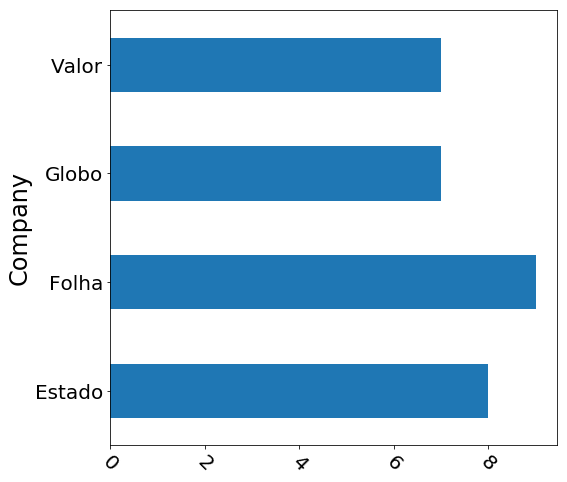

In [26]:
ax = df.groupby("Company")["Length"].median().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Claramente podemos ver que a "Folha de São Paulo", na média, utiliza mais palavras em suas manchetes.

### Criação de uma nova coluna para o tamanho de cada manchete - Stopwords

Stopwords: São palavras que podem ser consideradas irrelevantes para o conjunto de resultados a ser exibido em uma busca realizada em uma search engine [1]. Estas palavras são usadas para definir a estrutura de uma frase. Mas, não são de nenhum uso em definir o contexto.
Alguns exemplos de Stopwords:
* Linguagem – a, o, de, da, que, em, um.

Vamos repetir a mesma análise anterior, porém retirando as "stopwords". Para isso vamos utilizar um método da biblioteca NLTK, que nos fornece facilmente algumas stopwords da Lingua Portuguesa.

A função abaixo faz o split de cada manchete, conta as palavras sem as stopwords e atribui o valor númerico a uma nova coluna (Lenght_Filtered)

[1] http://www.agenciamestre.com/seo/stop-words-como-funcionam-palavras-de-parada/

In [30]:
stopwords = nltk.corpus.stopwords.words('portuguese')
df['Length_Filtered'] = df['Headline'].apply(lambda x: len(set(x.split()).difference(stopwords)) )
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6


### Número de médio de palavras sem stopwords

O gráfico abaixo ilustra o número médio de palavras utilizadas nas manchetes de cada Jornal


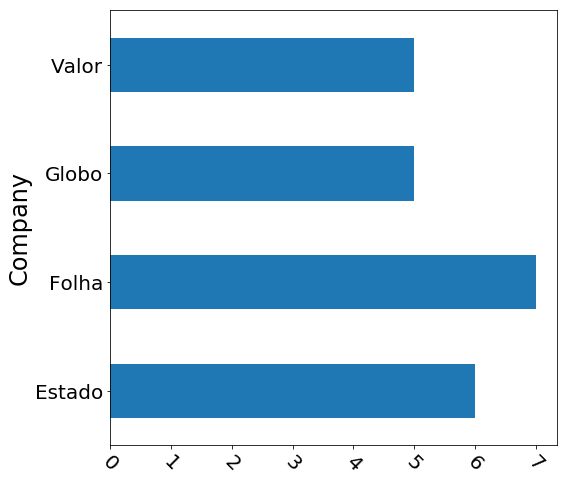

In [33]:
ax = df.groupby("Company")["Length_Filtered"].median().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Mesmo após a remoção das stopwors, o jornal "Folha de São Paulo" ainda tem o maior número médio de palavras em suas manchetes.

Esta pré análise vai nos ajudar a verificar se o número de palavras foi um fator relevante ou não na determinação da valência de cada manchete. 

# POS Tagging analysis using MAC Morpho

#### Below is the analysis of quantity and quality of MAC Morpho in respect of nouns, adjectives and verbs since we are more interested in learning how it works with the main types of tokes in Portuguese language.

In [ ]:
import nltk.corpus
dict_morpho = dict(nltk.corpus.mac_morpho.tagged_words())

In [ ]:
# function responsible to draw wordclouds
def wordcloud_draw(data, color = 'white', title= ""):
    words = ' '.join(data)
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(8, 8))
    plt.title(title, fontsize=20)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

### Creating new column for adjectives count of each sentence

In [ ]:
adjectives = []
def adj_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "ADJ":
                adj_count += 1
                adjectives.append(word)
        except:
            pass
    return adj_count
df['Adjectives_Count'] = df['Headline'].apply(lambda x: adj_count(x))
df.head()

### Worcloud for adjectives

In [ ]:
wordcloud_draw(adjectives, "white", "Adjectives WordCloud")

### Creating new column for nouns count of each sentence

In [ ]:
nouns = []
def sub_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "N":
                adj_count += 1
                nouns.append(word)
        except:
            pass
    return adj_count
df['Nouns_Count'] = df['Headline'].apply(lambda x: sub_count(x))
df.head()

### Worcloud for nouns

In [ ]:
wordcloud_draw(nouns, "white", "Nouns WordCloud")

### Creating new column for verbs count of each sentence

In [ ]:
verbs = []
def verb_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "V":
                adj_count += 1
                verbs.append(word)
        except:
            pass
    return adj_count
df['Verbs_Count'] = df['Headline'].apply(lambda x: verb_count(x))
df.head()

### Worcloud for verbs

In [ ]:
wordcloud_draw(verbs, "white", "Verbs WordCloud")

#### As we can see, MAC Morpho achieved a good result classifying the tokens but could improve specially dealing with verbs without its infinitive form. Lemmatizer could solve this problem but Mac Morpho don't accomplish all kinds of lemmatizer tokens.

## Analyzing the frequency

In [ ]:
# Remove all stopwords
dataframe = pd.DataFrame(df['Headline'])

names = []
def funcao(sentence):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    words = [w for w in sentence.lower().split() if w not in stopwords and w.isalpha()]
    
    return words

dataframe['stopwords'] = df['Headline'].apply(lambda x: funcao(x))
dataframe.head()

In [ ]:
all_words = []
for x in dataframe.stopwords:
    for y in x:
        all_words.append(y)

fd_words = nltk.FreqDist(all_words)
for i,x in enumerate(fd_words.most_common()):
    if i < 20:
        print(x)

In [ ]:
#Identify duplicate news
aux = df[['Company','Headline']][df.Headline.duplicated(keep=False)] #value_counts(sort=True)
print ("The dataset has", aux.Headline.count(),"news duplicated")
#print (aux.Headline.count())
aux.sort_values("Headline",ascending=True)

# Lexical Analysis

Lexical Python file was based in https://github.com/pedrobalage/STIL_LIWC_Evaluation. It's just two classes for using:
- OpLexiconReader - OPLexicon 3.0
- SentiLexReader - Sentilex PT02

These are common dictionaries for Portuguese lexical use, including polarities for some words and expressions.

Polarities in both are expressed as:

- -1: Negative sentiment
- 0: Neutral sentiment
- 1: Positive sentiment

In [ ]:
#import lexical
from lexical import OpLexiconReader
from lexical import SentiLexReader
from lexical import LiwcReader

#### Example of OpLexicon 3.0

In [ ]:
oplexicon = OpLexiconReader()
sentence = df["Headline"][1].split()
for w in sentence:
    print(w, oplexicon.polarity(w))

#### Example of SentiLex PT02

In [ ]:
sentilex =  SentiLexReader()
for w in sentence:
    print(w, sentilex.polarity(w))

#### Example of LIWC

In [ ]:
liwc =  LiwcReader()
for w in sentence:
    print(w, liwc.polarity(w))

#### The result above for both lexicals give us an alert that many words aren't present in these Portuguese lexicals. However, we will try to do sentiment analysis based on them.

# Sentiment Analysis

#### The function below returns the polarity from the proper lexical. In order to keep dimensions between -1 and 1, we decided to sum up all polarities and take the mean related to the words that the lexical contains. So, words that are not present in the lexicals don't count in the final mean. In this way, sentiment analysis using the lexicals could be a little more accurated.

In [ ]:
def extract_sentiment_lexical(sentence, lexical):
    model = oplexicon if lexical == "oplexicon" else liwc if lexical =="liwc" else sentilex
    original_words = sentence.split()
    stopwords = nltk.corpus.stopwords.words('portuguese')
    #words = [w for w in original_words] 
    words = [w for w in original_words if w not in stopwords and w.isalpha()]  

    sum_lexical, count_lexical = 0, 0
    for w in words:
        pol_lexical = model.polarity(w)
        if pol_lexical is not None:
            sum_lexical += pol_lexical
            count_lexical += 1
        
    mean_lexical = sum_lexical/count_lexical if count_lexical != 0 else 0
    #print(sentence, mean_lexical)
    return mean_lexical
    
df['OpLexicon_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "oplexicon"))
df['SentiLex_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "sentilex"))
df['LIWC_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "liwc"))
df.head()

In [ ]:
import datetime as dt

dict1 = {'janeiro':1,
         'fevereiro':2,
         'março':3, 
         'abril':4,
         'maio':5,
         'junho':6,
         'julho':7,
         'agosto':8,
         'setembro':9,
         'outubro':10, 
         'novembro':11,
         'dezembro':12}
df['Month_number'] = df.Month.map(dict1)

df.head()

In [ ]:
df['DateTime'] = df[['Year', 'Month_number', 'Day']].apply(lambda s : dt.datetime(*s),axis = 1)
df.head()

In [ ]:
df.index = df.DateTime

#ax = df.set_index(df.Month).sort_index().groupby("Month",sort=False, axis=0)["OpLexicon_Score","SentiLex_Score","LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))
ax = pd.Series.groupby(df,by=[df.index.month,df.index.year],sort=True, axis=0)["OpLexicon_Score","SentiLex_Score","LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)


# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

#### Histograms from each dictionary

In [ ]:
df["OpLexicon_Score"].hist()

In [ ]:
df["SentiLex_Score"].hist()

In [ ]:
df["LIWC_Score"].hist()

### OpLexicon Score Analysis by Company

In [ ]:
ax = df.groupby("Company")["OpLexicon_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

### SentiLex Score Analysis by Company

In [ ]:
ax = df.groupby("Company")["SentiLex_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

# Real Time Headlines Analysis

#### In order to analyse and compare which news are most important in the moment and their polarity, we propose a real time sentiment parser for both Folha, Valor and O Globo websites.

In [ ]:
def parser(website):
    r = requests.get(website)
    content = r.content
    soup = BeautifulSoup(content, "html.parser")
    headings = soup.find_all(re.compile(r"^h\d$"))
    company = []
    for h in headings:
        # avoid ads
        if len(h.text.strip().split()) > 6:
            company.append(str.strip(h.text))
    return company

In [ ]:
valor_news = parser("http://www.valor.com.br/")
globo_news = parser("https://oglobo.globo.com/")
folha_news = parser("http://www.folha.uol.com.br/")

## Folha Top 10

In [ ]:
for sentence in folha_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

In [ ]:
words = []
for sentence in folha_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud Folha")

## Valor Top 10

In [ ]:
for sentence in valor_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

In [ ]:
words = []
for sentence in valor_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud Valor")

## O Globo Top 10

In [ ]:
for sentence in globo_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

In [ ]:
words = []
for sentence in globo_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud O Globo")